In [1]:
import os
from typing_extensions import Literal
from langchain_core.messages import HumanMessage, SystemMessage
from langchain_community.chat_models import ChatTongyi
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display
from pydantic import BaseModel, Field
import operator


In [2]:
# os.environ["LANGSMITH_API_KEY"] = getpass.getpass("Enter your LangSmith API key: ")
os.environ["LANGSMITH_TRACING"] = "true"
os.environ["LANGSMITH_PROJECT"] = "orchestrator-worker"

In [3]:
llm = ChatTongyi(
    model="qwen-max",
)

In [4]:
# Schema for structured output to use in planning
from typing import List


class Section(BaseModel):
    name: str = Field(
        description="Name for this section of the report.",
    )
    description: str = Field(
        description="Brief overview of the main topics and concepts to be covered in this section.",
    )


class Sections(BaseModel):
    sections: List[Section] = Field(
        description="Sections of the report.",
    )


# Augment the LLM with schema for structured output
planner = llm.with_structured_output(Sections)

In [ ]:
from typing import Annotated
from langgraph.types import Send


# Graph state
class State(TypedDict):
    topic: str  # Report topic
    sections: list[Section]  # List of report sections
    completed_sections: Annotated[
        list, operator.add
    ]  # All workers write to this key in parallel
    final_report: str  # Final report


# Worker state
class WorkerState(TypedDict):
    section: Section
    completed_sections: Annotated[list, operator.add]

# 多个worker并行写入WorkerState中的completed_sections
# LangGraph会自动将所有worker的结果合并到主State中的completed_sections
# 参考https://langchain-ai.github.io/langgraph/how-tos/graph-api/#pass-private-state-between-nodes

# Nodes
def orchestrator(state: State):
    """Orchestrator that generates a plan for the report"""

    # Generate queries
    report_sections = planner.invoke(
        [
            SystemMessage(content="Generate a plan for the report."),
            HumanMessage(content=f"Here is the report topic: {state['topic']}"),
        ]
    )

    return {"sections": report_sections.sections}


def llm_call(state: WorkerState):
    """Worker writes a section of the report"""

    # Generate section
    section = llm.invoke(
        [
            SystemMessage(
                content="Write a report section following the provided name and description. Include no preamble for each section. Use markdown formatting."
            ),
            HumanMessage(
                content=f"Here is the section name: {state['section'].name} and description: {state['section'].description}"
            ),
        ]
    )

    # Write the updated section to completed sections
    return {"completed_sections": [section.content]}


def synthesizer(state: State):
    """Synthesize full report from sections"""

    # List of completed sections
    completed_sections = state["completed_sections"]

    # Format completed section to str to use as context for final sections
    completed_report_sections = "\n\n---\n\n".join(completed_sections)

    return {"final_report": completed_report_sections}


# Conditional edge function to create llm_call workers that each write a section of the report
def assign_workers(state: State):
    """Assign a worker to each section in the plan"""

    # Kick off section writing in parallel via Send() API
    return [Send("llm_call", {"section": s}) for s in state["sections"]]






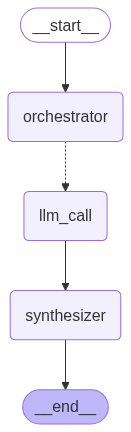

In [8]:
# Build workflow
orchestrator_worker_builder = StateGraph(State)

# Add the nodes
orchestrator_worker_builder.add_node("orchestrator", orchestrator)
orchestrator_worker_builder.add_node("llm_call", llm_call)
orchestrator_worker_builder.add_node("synthesizer", synthesizer)

# Add edges to connect nodes
orchestrator_worker_builder.add_edge(START, "orchestrator")
orchestrator_worker_builder.add_conditional_edges(
    "orchestrator", assign_workers, ["llm_call"]
)
orchestrator_worker_builder.add_edge("llm_call", "synthesizer")
orchestrator_worker_builder.add_edge("synthesizer", END)

# Compile the workflow
orchestrator_worker = orchestrator_worker_builder.compile()

# Show the workflow
display(Image(orchestrator_worker.get_graph().draw_mermaid_png()))

In [10]:
# Invoke
state = orchestrator_worker.invoke({"topic": "Create a report on LLM scaling laws"})

from IPython.display import Markdown
Markdown(state["final_report"])

## Introduction to LLM Scaling Laws

Large Language Model (LLM) scaling laws refer to the empirical observations and theoretical frameworks that describe how the performance of language models changes as a function of their size, the amount of training data, and the computational resources used during training. These laws are crucial in the field of artificial intelligence as they provide insights into the expected capabilities and limitations of LLMs, guiding both research and practical applications.

The importance of LLM scaling laws lies in their ability to predict model performance improvements with increases in scale. This predictive power is essential for resource allocation, as it helps in determining the optimal balance between model size, training data, and computational budget. Understanding these scaling laws also aids in setting realistic expectations about the potential of LLMs, thereby influencing strategic decisions in AI development and deployment.

In the context of developing large language models, scaling laws inform the design and training processes. They suggest that, up to a certain point, increasing the number of parameters, the volume of training data, or the computational power can lead to significant gains in model accuracy and capability. However, these gains often follow a diminishing returns pattern, where each additional unit of increase yields progressively smaller improvements. This understanding is critical for optimizing the cost-effectiveness of LLM development and ensuring that advancements in AI are sustainable and impactful.

---

## Theoretical Foundations

The theoretical underpinnings of Large Language Model (LLM) scaling are rooted in a combination of mathematical models and empirical evidence. These theories aim to explain the observed performance improvements as the size of these models, measured in parameters, increases. Key aspects include:

### Mathematical Models
1. **Power Law Scaling**:
   - A prominent model suggests that the loss \( L \) (a measure of error or performance) scales with the number of parameters \( N \) according to a power law: 
     \[
     L(N) \propto N^{-\alpha}
     \]
   - Here, \( \alpha \) is a positive exponent that characterizes the rate at which the loss decreases as the model size increases. Empirical studies have found that \( \alpha \) typically lies between 0.1 and 0.3.

2. **Computational Complexity**:
   - The computational complexity of training an LLM is often modeled as \( O(N^2) \) or \( O(N^3) \), depending on the specific architecture and optimization techniques used. This reflects the quadratic or cubic increase in computational resources required as the number of parameters grows.

### Empirical Evidence
1. **Scaling Laws**:
   - Empirical studies, such as those conducted by researchers at Google and OpenAI, have shown that the performance of LLMs improves predictably with the number of parameters. For instance, the "Scaling Laws for Neural Language Models" paper by Kaplan et al. (2020) provides a detailed analysis of how test loss scales with model size, dataset size, and compute budget.
   - These studies indicate that the benefits of increasing model size follow a logarithmic relationship, meaning that doubling the number of parameters leads to a smaller but consistent improvement in performance.

2. **Dataset Size and Quality**:
   - The quality and size of the training dataset also play a crucial role in the scaling behavior of LLMs. Larger and more diverse datasets generally lead to better performance, but there is a point of diminishing returns where additional data has less impact on performance.
   - Empirical evidence suggests that the optimal dataset size for a given model size can be estimated using similar power laws, indicating a balance between the amount of data and the model's capacity.

3. **Compute Efficiency**:
   - The efficiency of compute usage is another critical factor. Studies have shown that the compute-optimal model size, which maximizes performance per unit of compute, follows a specific scaling law. This is important for practical applications where computational resources are limited.

### Implications
- **Model Design**:
  - Understanding these scaling laws helps in designing more efficient and effective LLMs. For example, it informs decisions about the trade-offs between model size, dataset size, and computational resources.
- **Economic Considerations**:
  - The scaling laws also have significant economic implications, as they help in estimating the cost-benefit of investing in larger models versus improving other aspects of the training pipeline, such as data quality or optimization algorithms.

In summary, the theoretical foundations of LLM scaling are supported by both rigorous mathematical models and extensive empirical evidence. These insights provide a robust framework for understanding and predicting the performance of LLMs as they continue to grow in size and complexity.

---

## Practical Implications

The scaling laws of Large Language Models (LLMs) have profound implications for real-world applications, influencing everything from the allocation of computational resources to the expected performance and efficiency of the models. Understanding these impacts is crucial for organizations and researchers looking to leverage LLMs effectively.

### Resource Allocation for Training
One of the most immediate practical implications of LLM scaling laws is the significant demand for computational resources. As model size increases, so does the requirement for high-performance computing infrastructure, including GPUs, TPUs, and specialized AI accelerators. This necessitates substantial investment in hardware, energy, and cooling systems, which can be a barrier for smaller organizations or those with limited budgets. Additionally, the time required to train larger models grows, impacting project timelines and resource planning. Organizations must carefully consider the trade-offs between model size and training feasibility, often opting for more efficient training strategies or leveraging pre-trained models to reduce costs and time.

### Model Performance
Scaling laws suggest that as the number of parameters in an LLM increases, there is a corresponding improvement in model performance across various tasks. This means that larger models generally exhibit better accuracy, generalization, and ability to handle complex and nuanced language tasks. For applications such as natural language understanding, machine translation, and content generation, this translates into more reliable and sophisticated outputs. However, the gains in performance are not linear; at some point, the marginal improvements become less pronounced, and the cost-benefit ratio must be carefully evaluated.

### Efficiency and Deployment
While larger models offer superior performance, they also pose challenges in terms of deployment and inference. The computational and memory requirements for running large models can be prohibitive, especially in environments with limited resources, such as mobile devices or edge computing. To address this, techniques like model pruning, quantization, and distillation are employed to create smaller, more efficient versions of the models without significantly compromising performance. These methods allow for the deployment of LLMs in a wider range of applications, making them more accessible and practical for real-world use cases.

### Ethical and Environmental Considerations
The practical implications of LLM scaling laws extend beyond technical and operational aspects. The environmental impact of training and deploying large models is a growing concern, given the substantial energy consumption and carbon footprint associated with high-performance computing. Organizations must consider the ethical implications of their resource usage and strive for more sustainable practices, such as using renewable energy sources and optimizing model architectures for energy efficiency.

In summary, the scaling laws of LLMs have far-reaching practical implications, affecting resource allocation, model performance, and deployment efficiency. By understanding these impacts, stakeholders can make informed decisions that balance the benefits of larger models with the constraints of real-world applications, ensuring both technological advancement and responsible use.

---

## Case Studies

### Case Study 1: Scaling Laws in Language Translation
In this case, a major tech company applied LLM scaling laws to improve the performance of their language translation services. By increasing the number of parameters from 100 million to over 1 billion, they observed a significant improvement in BLEU scores across multiple language pairs. The primary lesson learned was that while there is a substantial initial gain in performance with increased model size, the rate of improvement diminishes after a certain threshold. This study highlighted the importance of balancing computational resources with expected gains in model performance.

### Case Study 2: Application in Medical Diagnosis
A research team used LLMs to predict medical diagnoses based on patient symptoms and medical history. They scaled their model from 50 million to 500 million parameters. The results showed a marked increase in diagnostic accuracy, particularly for rare diseases. However, the team also noted that the complexity of the model led to longer inference times, which could be a critical issue in time-sensitive medical settings. This case underscored the need for optimizing not just for accuracy but also for real-time performance in practical applications.

### Case Study 3: Enhancing Customer Service Chatbots
A large e-commerce platform implemented LLMs to enhance their customer service chatbots. Initially, they used a model with 200 million parameters, which was later scaled up to 2 billion parameters. The larger model significantly improved the naturalness and relevance of the responses, leading to higher customer satisfaction ratings. A key takeaway was the necessity of fine-tuning the model with domain-specific data to achieve optimal performance. This case demonstrated how scaling can be effectively combined with specialized training to meet specific business needs.

### Case Study 4: Financial Market Prediction
In an attempt to predict stock market trends, a financial firm experimented with LLMs ranging from 300 million to 3 billion parameters. While the models showed some improvements in predictive accuracy, the gains were modest compared to the computational costs. The firm concluded that for highly dynamic and complex systems like financial markets, the benefits of scaling alone are limited. This case highlighted the importance of integrating external data sources and advanced feature engineering alongside model scaling to achieve better outcomes.

### Summary
These case studies illustrate the varied impacts of applying LLM scaling laws in different domains. While there are clear benefits in terms of performance, these must be weighed against the associated costs and practical considerations. Each application area presents unique challenges and opportunities, emphasizing the need for a tailored approach to model scaling.

---

## Challenges and Limitations

Scaling Large Language Models (LLMs) to achieve better performance and broader applicability comes with a set of significant challenges and limitations. These issues not only affect the development and deployment of LLMs but also highlight critical areas for future research and improvement.

### Resource Intensity
One of the primary challenges in scaling LLMs is the substantial computational and energy resources required. Training large models involves processing vast amounts of data, which demands high-performance computing infrastructure. This resource intensity not only increases costs but also raises environmental concerns due to the carbon footprint associated with such operations. Future research could focus on developing more efficient training algorithms and hardware that can reduce both the computational and energy requirements.

### Data Quality and Bias
The performance of LLMs is heavily dependent on the quality and diversity of the training data. Poorly curated datasets can lead to biased or inaccurate model outputs. Additionally, biases present in the training data can be amplified by the model, leading to unfair or discriminatory results. Addressing this challenge requires robust data curation processes and the development of techniques to detect and mitigate bias in LLMs. Research into more inclusive and representative datasets, as well as methods for continuous bias monitoring and correction, is essential.

### Model Interpretability and Explainability
As LLMs become larger and more complex, they often become "black boxes," making it difficult to understand how they arrive at their decisions. This lack of interpretability and explainability can be a significant barrier to their adoption in critical applications, such as healthcare and finance, where transparency and accountability are paramount. Future work should focus on developing methods to make LLMs more interpretable, such as attention visualization, feature attribution, and other explainable AI (XAI) techniques.

### Scalability and Deployment
Deploying LLMs at scale presents several logistical and technical challenges. Large models require significant memory and computational power, which can be prohibitive for many organizations. Additionally, ensuring consistent and reliable performance across different environments and use cases is a non-trivial task. Research into model compression, quantization, and efficient inference techniques can help make LLMs more accessible and deployable. Furthermore, exploring cloud-based and edge computing solutions can provide more flexible and scalable deployment options.

### Ethical and Legal Considerations
The use of LLMs raises important ethical and legal questions, particularly around privacy, security, and the potential for misuse. Ensuring that LLMs are used responsibly and ethically is a critical challenge. This includes developing guidelines and regulations for the use of LLMs, as well as implementing robust security measures to protect against data breaches and malicious attacks. Future research should focus on creating frameworks and standards that address these ethical and legal considerations, ensuring that LLMs are developed and deployed in a responsible manner.

### Continuous Learning and Adaptation
LLMs need to continuously learn and adapt to new information and changing contexts. However, current models often struggle with this, as they are typically trained on static datasets and do not easily incorporate new data without retraining. Developing methods for online learning and continual adaptation, where models can update their knowledge incrementally, is a key area for future research. This would enable LLMs to stay relevant and up-to-date in dynamic environments.

In summary, while LLMs have shown remarkable capabilities, addressing the challenges and limitations associated with their scaling is crucial for their sustainable and responsible development. Future research should focus on improving efficiency, mitigating bias, enhancing interpretability, facilitating deployment, and ensuring ethical and legal compliance.

---

## Conclusion and Future Directions

In this report, we have explored the critical aspects of Large Language Models (LLMs) and their scaling laws, which are pivotal in understanding the growth and capabilities of AI. We began by defining LLMs and discussed how they have evolved to become more sophisticated and versatile, capable of performing a wide range of tasks from natural language understanding to complex problem-solving. The discussion then delved into the concept of scaling laws, which describe the relationship between the size of a model, the amount of training data, and the computational resources required to achieve optimal performance. These laws not only provide insights into the efficiency and effectiveness of LLMs but also guide the development of future models.

Key points covered include:
- The foundational architecture and training methodologies of LLMs.
- The empirical evidence supporting the existence of scaling laws and their implications for model performance.
- The challenges and limitations associated with scaling, such as increased computational costs and environmental impacts.
- The ethical considerations and societal impacts of deploying large-scale AI systems.

Looking ahead, the future of LLMs and their scaling laws is poised to significantly influence the trajectory of AI technology. As researchers continue to refine and expand on these models, we can expect to see more efficient and sustainable practices in AI development. Additionally, advancements in hardware and algorithmic optimizations will likely play a crucial role in overcoming current limitations. The integration of LLMs with other forms of AI, such as computer vision and robotics, could lead to even more powerful and versatile systems. Furthermore, ongoing research into the interpretability and transparency of these models will be essential for building trust and ensuring that AI technologies are used responsibly and ethically.